# Land cover classification using sentinel 2 Imagery: a glance of how to work under static modellling 

This paper attempts to document the process of supervised classification of one satelite image of the sensor sentinel 2 using COS data under the environment of python. In this sense, the results are going to be used as baseline of a multitemporal analysis of the year 2017. This reference look for evaluating performance of a static model using different assumptions about how to integrate COS training data in the classification task. Moreover, this performance will lead to set challenges and possible improvements that the integration of the temporal domain may reach out in this thesis.

## Importing Training data

The training data for this classification corresponds to COS after having implemented the analysis of entropies. Therefore, we account with a training dataset composed by 7500 samples categorized by 10 different classes. Bushes_and_shrubs, Coniferous trees, Eucalyptus trees, Herbaceous, Holm and Cork Trees, Non_vegetated, Rice_fields, Sealed, Water, Wetlands.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn import svm
import matplotlib.pyplot as plt
import lulc
import Active_learning as al
import os
import numpy as np
import pandas as pd

#path_shape = r'/home/user/Documents/TESISMASTER/VECTOR/Training_data_Imagery/IM_20170729/training_samples4_rf_w_query_80.shp'
path_shape = r'/home/user/Documents/TESISMASTER/VECTOR/Training_data_composites_max_ndvi_ST_Filter/Summer_composite/training_samples6_rf_w_queryB_75.shp'
dataset = al.import_data(path_shape)
#print(dataset["data"])

<bound method FieldDefn.GetType of <osgeo.ogr.FieldDefn; proxy of <Swig Object of type 'OGRFieldDefnShadow *' at 0x7ff72c66e780> >>


THe variables corresponds to the pixel values of the bands that come from the composite of summer. So the variables are the following: B02: Blue; B03:Green; B04: Red, B05,B06,B07: Vgetation red edge; B08: NIR; B11, B12: SWIR; B8A: Narrow NIR; NDVI; ZDEM; ZSLOPE.  

In [22]:
from sklearn.preprocessing import StandardScaler
data = dataset["data"].iloc[:,1:15]
col_names = data.dtypes.index.tolist()
data_standard = data #StandardScaler().fit_transform(data)
data_standard_df = pd.DataFrame(data_standard,columns = col_names)
labels = dataset["data"].iloc[:,0]
dataset_standard_df = pd.concat([labels,data_standard_df], axis = 1)
dataset_standard = {
    "coordinates":dataset["coordinates"],
    "data":dataset_standard_df,
    "proj":dataset["proj"]
}
#print(dataset_standard)

## Counting

Number of samples per class. This dataset contains the 75% most infomative samples in the classification of the composite of summer.

7500


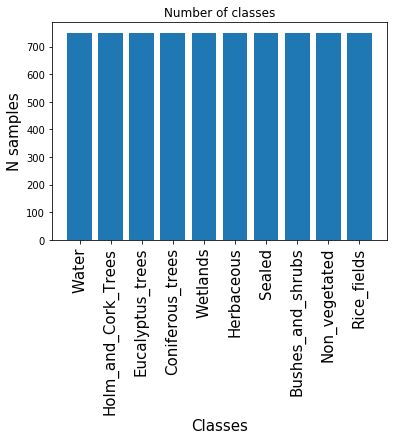

In [6]:
np.unique(dataset_standard["data"]["CLASS_NAME"])
table = dataset_standard["data"].CLASS_NAME.value_counts()
print(table.sum())

label_count = table.tolist()
label = table.index.values
index = np.arange(len(label))

plt.bar(index, label_count)
plt.xlabel('Classes', fontsize=15)
plt.ylabel('N samples', fontsize=15)
plt.xticks(index, label, fontsize=15, rotation=90)
plt.title('Number of classes')
plt.show()

I will split the data (75%) in two new data sets, one 30 % correspond to a test and 70 % to a training 

In [23]:
random = al.random_selection(dataset_standard,prob = 0.7, pivot= "CLASS_NAME")
(train,test) = random.stratified_random_selection()
#print(train["data"])

In [24]:
X_train = train["data"].iloc[:,1:14].values
y_train = train["data"]["CLASS_NAME"].values
X_test = test["data"].iloc[:,1:14].values
y_test = test["data"]["CLASS_NAME"].values
#weights = train["data"]["weights"].values
#print(weights[1:2])

# Random forest classifier

In [9]:
classifier= RandomForestClassifier(n_estimators=500)
classifier.fit(X_train,y_train)
result = classifier.predict(X_test)
print('done')

done


## Confusion matrix

In [10]:
np.unique(y_test)

array(['Bushes_and_shrubs', 'Coniferous_trees', 'Eucalyptus_trees',
       'Herbaceous', 'Holm_and_Cork_Trees', 'Non_vegetated',
       'Rice_fields', 'Sealed', 'Water', 'Wetlands'], dtype=object)

Normalized confusion matrix


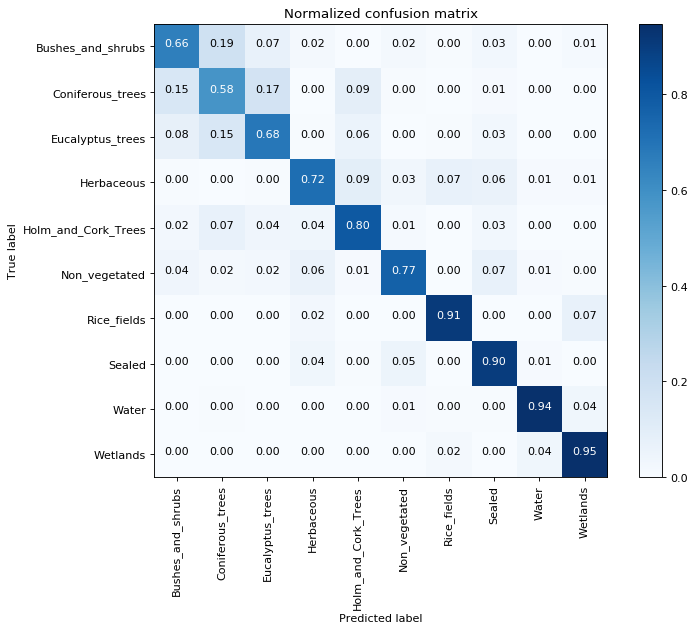

In [11]:
cm = confusion_matrix(y_test,result,labels = np.unique(y_test))
np.set_printoptions(precision=2)
plt.figure(figsize = (10,8), dpi=80)
lulc.plot_confusion_matrix(cm, classes=np.unique(y_test), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [12]:
print('Overal Accuracy: ', accuracy_score(result, y_test))

Overal Accuracy:  0.7902222222222223


In [13]:
print('Cohen_kappa: ', cohen_kappa_score(result, y_test))

Cohen_kappa:  0.7669135802469136


## Support vector machine

In [14]:
from sklearn import svm

In [15]:
classifier_svm =  svm.SVC(C=4, kernel = 'rbf',gamma= 0.25)  
classifier_svm.fit(X_train,y_train)
result = classifier_svm.predict(X_test)
print('done')

done


In [16]:
print('Overal Accuracy: ', accuracy_score(result, y_test))

Overal Accuracy:  0.8075555555555556


In [17]:
print('Cohen_kappa: ', cohen_kappa_score(result, y_test))

Cohen_kappa:  0.7861728395061729


Normalized confusion matrix


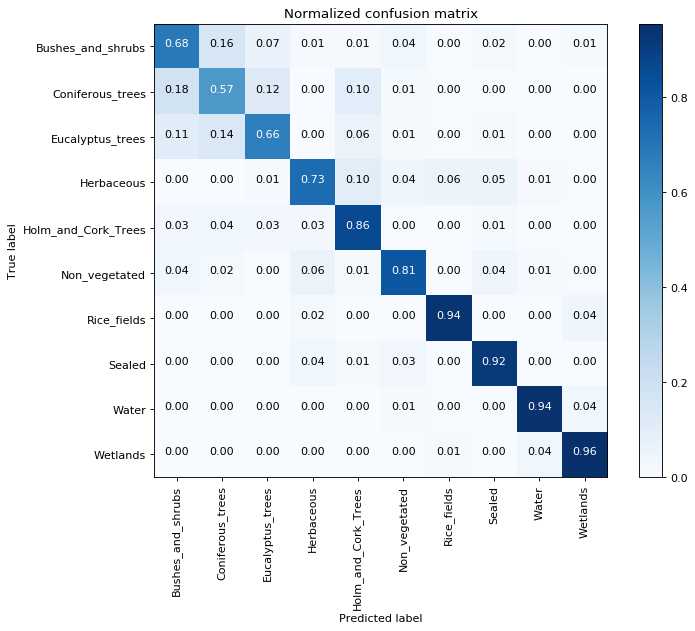

In [18]:
cm = confusion_matrix(y_test,result,labels = np.unique(y_test))
np.set_printoptions(precision=2)
plt.figure(figsize = (10,8), dpi=80)
lulc.plot_confusion_matrix(cm, classes=np.unique(y_test), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Tunning parameters support vector machine

In [19]:
#gamma
power = list(range(-8,4))
base = np.repeat(2,12)
gamma = [float(j)**float(i) for j,i in zip(base, power)]
print(power)
print(gamma)
# C
power = list(range(-2,8))
base = np.repeat(2,10)
C = [float(j)**float(i) for j,i in zip(base, power)]
print(C)

[-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]
[0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]


In [27]:
oa = []
for i in gamma:
    lin = []
    for j in C:
        classifier_svm =  svm.SVC(C=j, kernel = 'rbf', gamma=i)  
        classifier_svm.fit(X_train,y_train)
        result = classifier_svm.predict(X_test)
        lin.append(accuracy_score(result, y_test))
        classifier_svm = None
    oa.append(lin)
    print(f"done {i}")
print("done")


done 0.00390625
done 0.0078125
done 0.015625
done 0.03125
done 0.0625
done 0.125
done 0.25
done 0.5
done 1.0
done 2.0
done 4.0
done 8.0
done


In [28]:
oa_array = np.asarray(oa)
print(oa_array)

[[0.59 0.62 0.66 0.7  0.72 0.75 0.77 0.79 0.8  0.82]
 [0.62 0.67 0.7  0.72 0.75 0.77 0.79 0.81 0.82 0.82]
 [0.67 0.71 0.73 0.75 0.78 0.8  0.81 0.82 0.83 0.83]
 [0.7  0.73 0.75 0.78 0.8  0.81 0.82 0.82 0.83 0.83]
 [0.72 0.75 0.78 0.8  0.82 0.82 0.83 0.83 0.83 0.83]
 [0.74 0.77 0.79 0.81 0.82 0.82 0.82 0.83 0.82 0.82]
 [0.75 0.78 0.8  0.81 0.82 0.82 0.82 0.81 0.81 0.8 ]
 [0.76 0.79 0.8  0.81 0.81 0.82 0.81 0.79 0.78 0.78]
 [0.75 0.78 0.79 0.8  0.8  0.79 0.78 0.77 0.76 0.76]
 [0.7  0.75 0.77 0.77 0.77 0.75 0.75 0.74 0.74 0.74]
 [0.52 0.64 0.71 0.72 0.71 0.71 0.71 0.71 0.71 0.71]
 [0.29 0.39 0.6  0.61 0.61 0.61 0.61 0.61 0.61 0.61]]


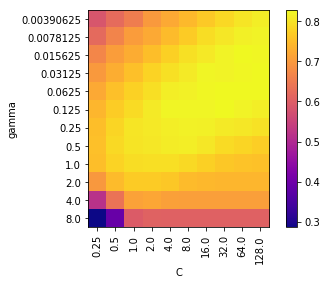

In [29]:
import matplotlib.pyplot as plt
plt.imshow(oa_array, interpolation='nearest', cmap = plt.plasma())
plt.colorbar()
plt.ylabel('gamma')
plt.xlabel('C')
tick_marks_gamma = np.arange(len(gamma))
tick_marks_c = np.arange(len(C))
plt.yticks(tick_marks_gamma, gamma)
plt.xticks(tick_marks_c, C,rotation= 90)
plt.show()